## 实验：轮廓层次应用

### 实验目标

在之前的实验中，我们通过应用不同的轮廓层次结构参数，绘制出对应的轮廓，并且通过分析轮廓层次矩阵，了解轮廓间的层次关系。

本实验将尝试把轮廓层次与现实应用关联，使您进一步了解轮廓层次在计算机视觉应用领域的必要性。假设您正在设计一个将螺栓接入螺母的系统，使用提供的图像，您需要找出以下各项的确切位置：

- 螺栓，以便机器人可以捡起它。
- 螺母内孔，以便机器人知道要接入螺栓的确切位置。

您的任务是在以下螺栓和螺母的二值图像中，检测出螺栓和螺母的内孔：

<img src="./img/20.jfif">

螺栓和螺母的内孔应分别标记为以下颜色：

<img src="./img/21.jfif">

### 1. 导入依赖库

In [3]:
import cv2                        # 导入OpenCV
import matplotlib.pyplot as plt   # 导入matplotlib

# 魔法指令，使图像直接在Notebook中显示
%matplotlib inline

### 2. 加载图像并保存副本

读取三通道黑白图像，由于我们将在后面的实验中其转换为单通道二值图像，因此，现在保存此三通道图像的副本，以便在实验结束时在其上绘制轮廓：

In [4]:
# 设置输入输出路径
import os
base_path = os.environ.get("BASE_PATH",'../data/')
data_path = os.path.join(base_path + "lab4/")
result_path = "result/"
os.makedirs(result_path, exist_ok=True)

# 读取图像文件
image_3chan = cv2.imread('./data/nut_bolt.png')     
# 拷贝保存副本
image_3chan_copy= image_3chan.copy()                

### 3. 显示图像

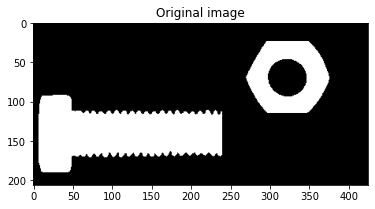

In [5]:
# 在云实验环境下忽略以下代码，避免程序尝试打开系统窗口显示图片；
# 使用matplotlib替换，使图像直接在 Jupyter Notebook 中输出。

# cv2.imshow( 'Original image' , image_3chan )
# cv2.waitKey(0) 
# cv2.destroyAllWindows()

plt.imshow(image_3chan[:,:,::-1])  # 将图像从 BGR 转换为 RGB
plt.title('Original image')        # 指定输出图像的标题
plt.show()                         # 显示图像

### 4. 转换灰度图像并二值化

将图像转换为灰度，然后，将其转换为二值图像（使用任何合适的阈值）并显示如下：

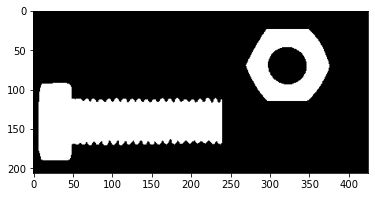

In [8]:
# 将图像转换为灰度图像    
gray_image = cv2.cvtColor(image_3chan,cv2.COLOR_BGR2GRAY)                 
# 直接输入阈值与最大值，执行图像二值化
ret,binary_im = cv2.threshold(gray_image,250,255,cv2.THRESH_BINARY) 

# 在云实验环境下忽略以下代码，避免程序尝试打开系统窗口显示图片；
# 使用matplotlib替换，使图像直接在 Jupyter Notebook 中输出。

# cv2.imshow( 'binary image' , binary_im )
# cv2.waitKey(0) 
# cv2.destroyAllWindows()

plt.imshow(binary_im, cmap='gray') # 使用灰色“喷涂”图像输出显示
plt.show()                         # 显示图像

在此二值图像中，我们需要检测螺栓的外边界和螺母的内边界。 就层次结构而言，螺栓是该图像中唯一没有父级轮廓和子级轮廓的轮廓。另一方面，螺母的内孔具有父轮廓，但没有子轮廓。 这就是我们接下来将如何区分两者的方式。

### 5. 轮廓检测

查找此图像中的所有轮廓，我们使用 `cv2.RETR_TREE` 模式获取轮廓，因为我们将需要它们的父子关系。

In [10]:
# 使用cv2.RETR_TREE选项，从而获取涵盖轮廓整个家族的详细族谱
contours_list,hierarchy = cv2.findContours(binary_im,
                                cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE) 

print('Hierarchy information of all contours:') # 设置输出提示
print (hierarchy)                               # 输出轮廓层次矩阵

Hierarchy information of all contours:
[[[ 1 -1 -1 -1]
  [-1  0  2 -1]
  [-1 -1 -1  1]]]


In [11]:
# 输出轮廓层次矩阵的行数
print(len(contours_list))                       

3


### 6. 轮廓层次矩阵

从上面我们可以看到 `hierarchy` 的输出是一个列表，其中还嵌套了一个列表 `hierarchy[0]`。 

此嵌套列表进一步由三个列表组成。

- hierarchy[0][0,:]
- hierarchy[0][1,:]
- hierarchy[0][2,:]

因此，我们可以通过 `for` 循环，遍历轮廓层析结构的信息。在下图中，您可以看到如何访问三个单独的列表：

<img src="./img/22.jfif">



### 7. 遍历轮廓层次结构信息

在 `for`循环中，我们现在将访问每个单独轮廓的层次结构信息。

对于每个轮廓的层次结构信息，我们设置一个 `if` 判断，用于检查最后两列。

- 如果两者均为 `-1`，则表示该轮廓没有父级，也没有子级。这意味着它是图像中 `螺栓` 的轮廓。我们将其绘制为 `绿色`以进行识别。
- 如果第三列是 `-1`，但第四列不是 `-1`, 则意味着它没有子级轮廓，但确实有一个父级轮廓。这意味着它是图像中 `螺母内孔` 的轮廓。我们将其绘制为 `红色`以进行识别。

In [12]:
# 创建for循环，从0开始，直到3行全部读取完毕
for i in range(0, len(contours_list)):                       
    # 设置循环变量i轮廓层次矩阵中的行数，即hierarchy[0][i, :] 
    contour_info= hierarchy[0][i, :]                          
    # 设置轮廓层次信息
    print('Hierarchy information of current contour:')        
    # 每次读取一行，输出轮廓层次信息
    print(contour_info)                                       
    # 如果没有子轮廓，没有父轮廓，判断为螺栓
    if contour_info[2]==-1 and contour_info[3]==-1:         
        with_contours = cv2.drawContours(image_3chan_copy,
                                         contours_list,i,[0,255,0],thickness=3) 
        # 在之前复制的副本图像上标记所有检测到的轮廓，用绿色（0,255,0） 绘制，将厚度设置为 3:
        
        # 显示已经找到螺栓
        print('Bolt contour is detected')                    
    # 如果没有子轮廓，有父轮廓，判断为螺母内孔
    if contour_info[2]==-1 and contour_info[3]!=-1:        
        with_contours = cv2.drawContours(with_contours,contours_list,
                                         i, [0,0,255],thickness=3)
         # 在之前复制的副本图像上标记所有检测到的轮廓，用红色（0,0,255） 绘制，将厚度设置为 3:
        # 显示已经找到螺母内孔
        print('Hole of nut is detected')                    
    

Hierarchy information of current contour:
[ 1 -1 -1 -1]
Bolt contour is detected
Hierarchy information of current contour:
[-1  0  2 -1]
Hierarchy information of current contour:
[-1 -1 -1  1]
Hole of nut is detected


### 8. 显示检测图像

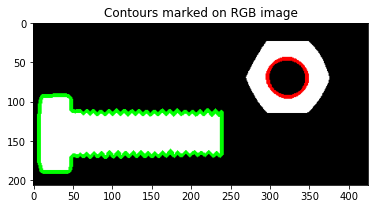

In [13]:
# 在云实验环境下忽略以下代码，避免程序尝试打开系统窗口显示图片；
# 使用matplotlib替换，使图像直接在 Jupyter Notebook 中输出。

# cv2.imshow( 'Contours marked on RGB image' , with_contours )
# cv2.waitKey(0) 
# cv2.destroyAllWindows()

# 使用matplotlib将图像转换为RGB
plt.imshow(with_contours[:,:,::-1])          
# 指定输出图像的标题
plt.title('Contours marked on RGB image')    
# 显示图像
plt.show()                                   

### 实验小结

在本实验中，您通过分析轮廓层次结构矩阵信息，实现了轮廓层次的实际应用。从而，了解存储在不同轮廓检索模式下的信息，在现实中的应用价值。